Basado en [https://www.williampnicholson.com/topic-modelling/](https://www.williampnicholson.com/topic-modelling/)

Embeddings

In [19]:
from datasets import load_dataset
import unidecode
dataset = load_dataset("csv",data_files="./preguntas_pnt_puebla_adjuntos.csv")
stopwords = ["puebla", "adjunto", "adjuntos", "adjunta", "adjuntas", "puebla,", "puebla.", "puebla:",
             "puebla?","de", "la", "en", "el", "que", "del", "los", "por", "se",
             "las", "con", "para", "al", "como", "su", "png", "lo", "no", "copia", "solicito",
             "es", "me", "si"]

def remove_words(input_string, words_to_remove):
    # Split the input string into a list of words
    input_string = unidecode.unidecode(input_string).lower()
    words = input_string.split()
    
    # Use a list comprehension to filter out the words to remove
    filtered_words = [word for word in words if word.lower() not in words_to_remove]
    
    # Join the filtered words back into a single string
    result_string = ' '.join(filtered_words)
    
    return result_string
docs_descripcion = dataset["train"]["descripcion"]
docs_adjuntos = dataset["train"]["adjuntos_solicitud.contenido"]

docs = []
for i,desc in enumerate(docs_descripcion):
  if (len(docs_adjuntos[i]) > 1):
    d = desc + " Adjunto: " + docs_adjuntos[i]
    d = remove_words(d, stopwords)
    docs.append(d[:7000])
  else:
    d = remove_words(desc, stopwords)
    docs.append(d[:7000])

In [20]:
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer("hiiamsid/sentence_similarity_spanish_es") # distiluse-base-multilingual-cased hiiamsid/sentence_similarity_spanish_es all-mpnet-base-v2
embeddings = embedding_model.encode(docs)

Dimensionality reduction

In [21]:
from umap import UMAP

umap_model = UMAP(
    # The size of local neighborhood (in terms of number of neighboring sample points) used for
    # manifold approximation.
    # Larger values result in more global views of the manifold, while smaller values result in
    # more local data being preserved. In general values should be in the range 2 to 100.
    n_neighbors=15,

    # The dimension of the space to embed into.
    # This defaults to 2 to provide easy visualization, but can reasonably be set to any
    # integer value in the range 2 to 100.
    n_components=5,

    min_dist=0.0,
    metric='cosine',
    random_state=42  # For reproducibility - to prevent stochastic behaviour of UMAP.
)

Clustering

In [22]:
from hdbscan import HDBSCAN

hdbscan_model = HDBSCAN(
    # Control the number of topics with this parameter.
    # The minimum size of clusters; single linkage splits that contain fewer points than
    # this will be considered points "falling out" of a cluster rather than a cluster splitting
    # into two new clusters.
    min_cluster_size=49,

    metric='euclidean',
    cluster_selection_method='eom',
    prediction_data=True
)

Tokenization

In [23]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer_model = CountVectorizer(
    ngram_range=(1, 6),
    # stop_words=spacy_stop_words,
    analyzer="word",

    # Ignore terms that have a document frequency strictly lower than the given threshold.
    min_df=1,
)

Weighting scheme

In [24]:
from bertopic.vectorizers import ClassTfidfTransformer

# We can choose any number of seed words for which we want their representation
# to be strengthen. We increase the importance of these words as we want them to be more
# likely to end up in the topic representations.
ctfidf_model = ClassTfidfTransformer(
    # seed_words=domain_specific_terms,
    seed_multiplier=2
)

Representation tuning

In [25]:
#!python3 -m spacy download es_dep_news_trf

In [26]:
from pathlib import Path

filename_llm = "llms/openhermes-2.5-mistral-7b.Q4_K_M.gguf"
if Path(filename_llm).is_file():
    print(f"Model {filename_llm} exists.")

else:
    url = 'https://huggingface.co/TheBloke/OpenHermes-2.5-Mistral-7B-GGUF/resolve/main/openhermes-2.5-mistral-7b.Q4_K_M.gguf'
    filename_llm = wget.download(url)
    print(f"Model {filename_llm} downloaded.")

from llama_cpp import Llama

# Use llama.cpp to load in a Quantized LLM.
llm = Llama(
    model_path=filename_llm,
    n_gpu_layers=-1,
    n_ctx=4096*4,
    stop=["Q:", "\n"]
)

from bertopic.representation import KeyBERTInspired, LlamaCPP, MaximalMarginalRelevance, PartOfSpeech

prompt = """Q:
Tengo un topico que contiene los siguientes documentos:
[DOCUMENTS]

El topico se describe con las siguientes palabras clave: '[KEYWORDS]'.
embedding_model
Basado en esa información, dame una breve etiqueta para el topico de 5 palabras como máximo.
A:
"""

# Create multiple representations of each topic that BERTopic creates.
# This way when you do e.g. "display(topic_model.get_topic_info()[1:11])" you
# can compare and contrast the different representations of the topics.
# Later on use "topic_model.get_topic_info()" to access all the representations.
representation_model = {
    "LLM": LlamaCPP(llm, prompt=prompt),  # The main pipeline is defined with the "main" key.
    "KeyBERT": KeyBERTInspired(),
    "Aspect1": PartOfSpeech("es_dep_news_trf"), # en_core_web_trf
    "Aspect2": [KeyBERTInspired(top_n_words=30), MaximalMarginalRelevance(diversity=.5)],
}

llama_model_loader: loaded meta data with 20 key-value pairs and 291 tensors from llms/openhermes-2.5-mistral-7b.Q4_K_M.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = teknium_openhermes-2.5-mistral-7b
llama_model_loader: - kv   2:                       llama.context_length u32              = 32768
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 4096
llama_model_loader: - kv   4:                          llama.block_count u32              = 32
llama_model_loader: - kv   5:                  llama.feed_forward_length u32              = 14336
llama_model_loader: - kv   6:                 llama.rope.dimension_count u32              = 128
llama_model_loader: - kv   7:             

Model llms/openhermes-2.5-mistral-7b.Q4_K_M.gguf exists.


llm_load_tensors: offloading 32 repeating layers to GPU
llm_load_tensors: offloading non-repeating layers to GPU
llm_load_tensors: offloaded 33/33 layers to GPU
llm_load_tensors:        CPU buffer size =    70.32 MiB
llm_load_tensors:      CUDA0 buffer size =  4095.06 MiB
.................................................................................................
llama_new_context_with_model: n_ctx      = 16384
llama_new_context_with_model: n_batch    = 512
llama_new_context_with_model: n_ubatch   = 512
llama_new_context_with_model: freq_base  = 10000.0
llama_new_context_with_model: freq_scale = 1
llama_kv_cache_init:      CUDA0 KV buffer size =  2048.00 MiB
llama_new_context_with_model: KV self size  = 2048.00 MiB, K (f16): 1024.00 MiB, V (f16): 1024.00 MiB
llama_new_context_with_model:  CUDA_Host  output buffer size =     0.12 MiB
llama_new_context_with_model:      CUDA0 compute buffer size =  1088.00 MiB
llama_new_context_with_model:  CUDA_Host compute buffer size =    40.01 Mi

Application of BERTopic

In [27]:
from bertopic import BERTopic

topic_model = BERTopic(
  language="multilingual",

  # Pipeline models.
  embedding_model=embedding_model,            # Step 1 - Extract embeddings.
  umap_model=umap_model,                      # Step 2 - UMAP model.
  hdbscan_model=hdbscan_model,                # Step 3 - Cluster reduced embeddings.
  vectorizer_model=vectorizer_model,          # Step 4 - Tokenize topics.
  ctfidf_model=ctfidf_model,                  # Step 5 - Strengthen topics.
  representation_model=representation_model,  # Step 6 - Label topics.

  # Hyperparameters.
  top_n_words=10,
  verbose=True,

  # Calculate the probabilities of all topics per document instead of
  # the probability of the assigned topic per document.
  # This could slow down the extraction of topics if you have many documents (> 100_000).
  # NOTE: If false you cannot use the corresponding visualization method
  #       visualize_probabilities.
  # NOTE: This is an approximation of topic probabilities as used
  #       in HDBSCAN and not an exact representation.
  calculate_probabilities=True,
)

topics, probs = topic_model.fit_transform(
    docs,
    embeddings,
)

2024-07-17 10:33:02,815 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-07-17 10:33:12,771 - BERTopic - Dimensionality - Completed ✓
2024-07-17 10:33:12,772 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-07-17 10:33:13,447 - BERTopic - Cluster - Completed ✓
2024-07-17 10:33:13,451 - BERTopic - Representation - Extracting topics from clusters using representation models.
  0%|                                                                                                                                                                                         | 0/13 [00:00<?, ?it/s]
llama_print_timings:        load time =     186.62 ms
llama_print_timings:      sample time =       4.91 ms /    16 runs   (    0.31 ms per token,  3259.32 tokens per second)
llama_print_timings: prompt eval time =     358.74 ms /   897 tokens (    0.40 ms per token,  2500.40 tokens per second)
llama_print_timings:        eval time =     173.60 ms /    15 

Visualization

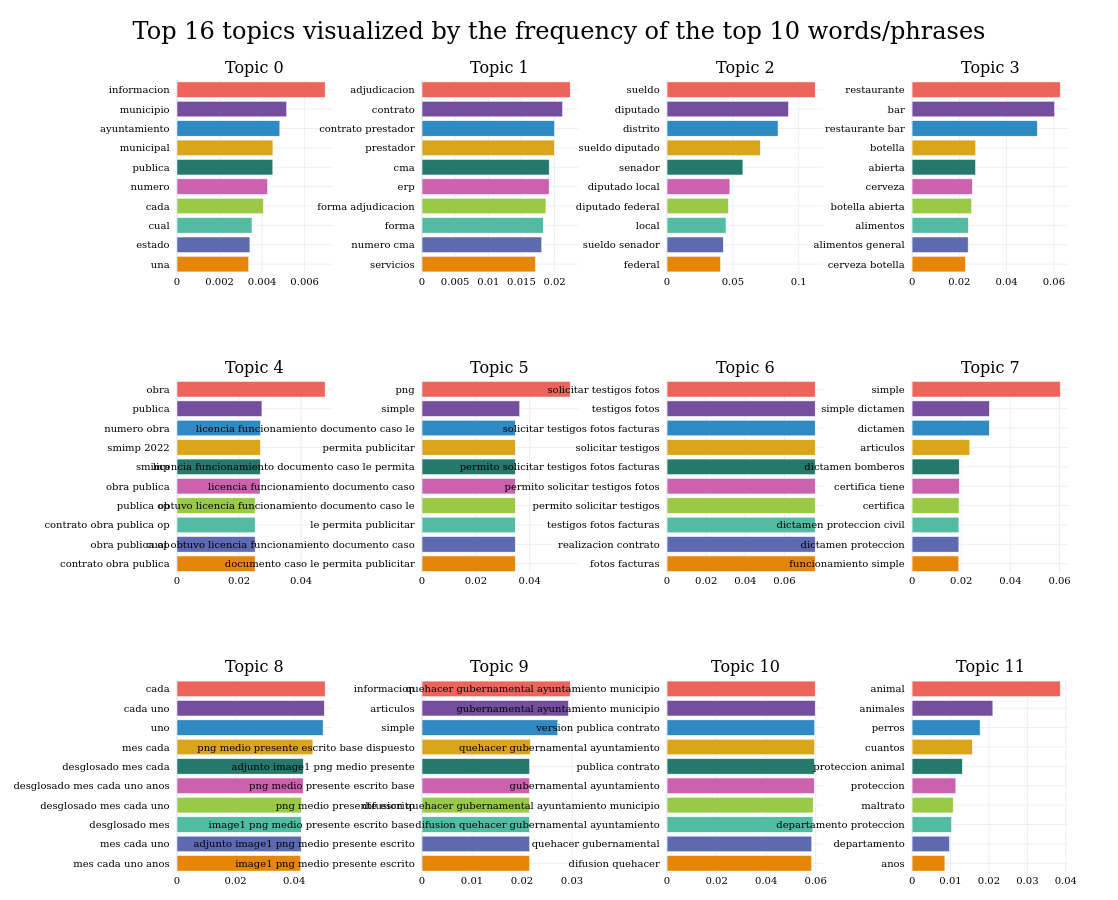

In [28]:
import plotly.express as px

top_n_topics = 16
n_words = 10

# 'fig_barchart' is a plotly figure.
fig_barchart = topic_model.visualize_barchart(
    top_n_topics = top_n_topics,  # Only select the top n most frequent topics.
    n_words = n_words,            # Number of words to show in a topic.
    custom_labels=True,          # Whether to use custom topic labels that were defined using topic_model.set_topic_labels.
    title=f"Top {top_n_topics} topics visualized by the frequency of the top {n_words} words",
    width=300,
    height=300,
)

fig_barchart.update_layout(
    # Adjust left, right, top, bottom margin of the overall figure.
    margin=dict(l=20, r=50, t=80, b=20),

    plot_bgcolor='rgba(0,0,0,0)',         # Set background color (transparent in this example).

    title={
        'text': f"Top {top_n_topics} topics visualized by the frequency of the top {n_words} words/phrases",
        'y':0.975,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(
            family="Roboto Black",
            size=24,
            color="#000000"
        )
    },

    font=dict(
        family="Roboto",
        size=10,
        color="#000000"
    ),
)

color_sequence = px.colors.qualitative.Vivid  # Choose a color sequence.
fig_barchart.update_traces(marker_color=color_sequence)

# Show the updated figure
fig_barchart.show()
fig_barchart.write_html('top 16 topics.html')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 16.72it/s]


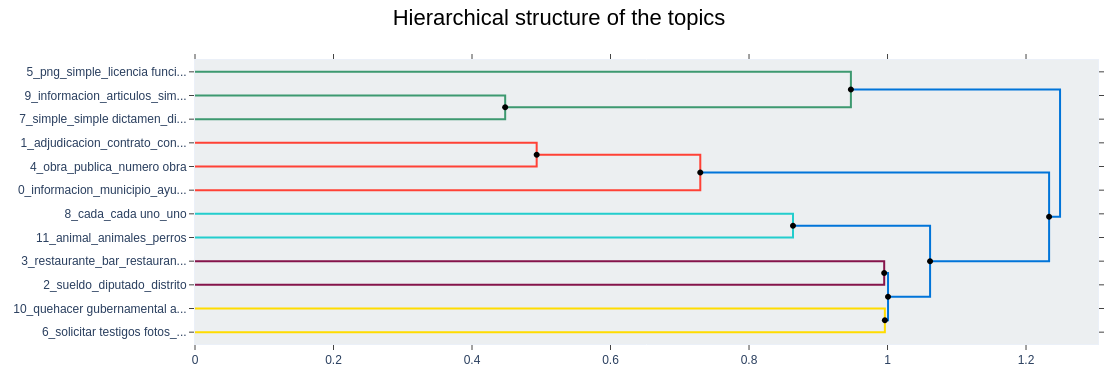

In [29]:
from scipy.cluster import hierarchy as sch
import pandas as pd

linkage_function = lambda x: sch.linkage(x, 'ward', optimal_ordering=True)

# Extract hierarchical topics and their representations.
# A dataframe that contains a hierarchy of topics represented by their parents and their children.
hierarchical_topics: pd.DataFrame = topic_model.hierarchical_topics(docs, linkage_function=linkage_function)

fig = topic_model.visualize_hierarchy(
    # 'str' the orientation of the figure. Either 'left' or 'bottom'.
    orientation='left',

    # 'list[int]' a selection of topics to visualize.
    topics=None,

    # 'int' only select the top n most frequent topics to visualize.
    top_n_topics=None,

    # 'pd.DataFrame' a dataframe that contains a hierarchy of topics represented by their
    # parents and their children.
    # NOTE: The hierarchical topic names are only visualized if both 'topics' and 'top_n_topics' are not set.
    hierarchical_topics=hierarchical_topics,

    # Whether to use custom topic labels that were defined using 'topic_model.set_topic_labels'.
    custom_labels=True,

    width=1200,
    height=1000,
)

fig.update_layout(
    # Adjust left, right, top, bottom margin of the overall figure.
    margin=dict(l=20, r=20, t=60, b=20),

    title={
        'text': "Hierarchical structure of the topics",
        'y':0.975,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(
            size=22,
            color="#000000"
        )
    },
)

fig.show()
fig.write_html('heriarchical.html')

In [30]:
reduced_embeddings = UMAP(n_neighbors=10, n_components=2, 
                          min_dist=0.0, metric='cosine').fit_transform(embeddings)

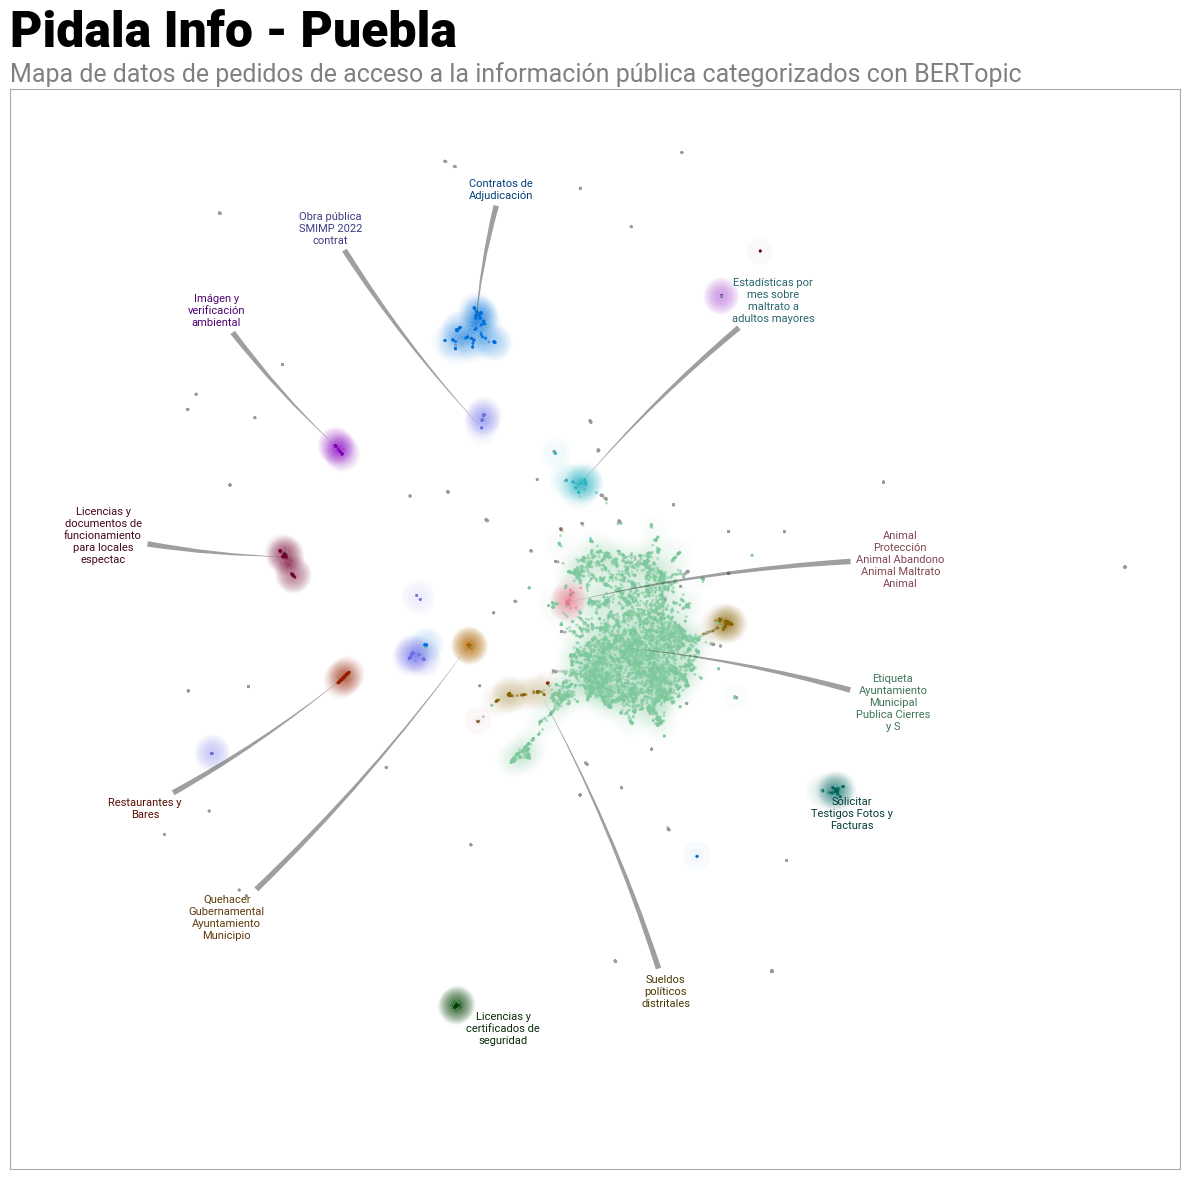

In [31]:

import datamapplot
import matplotlib.pyplot as plt
import re
llm_labels = [re.sub(r'\W+', ' ', label[0][0].split("\n")[0].replace('"', '')) for label in topic_model.get_topics(full=True)["LLM"].values()]
all_labels = [llm_labels[topic+topic_model._outliers] if topic != -1 else "Unlabelled" for topic in topics]
#all_labels = [llm_labels[topic] if topic != -1 else "Unlabelled" for topic in topics]
# Run the visualization
datamapplot.create_plot(
    reduced_embeddings,
    all_labels,

    use_medoids=True,

    # Follows matplotlib’s 'figsize' convention.
    # The actual size of the resulting plot (in pixels) will depend on the dots per inch (DPI)
    # setting in matplotlib.
    # By default that is set to 100 dots per inch for the standard backend, but it can vary.
    figsize=(12, 12),
    # If you really wish to have explicit control of the size of the resulting plot in pixels.
    dpi=100,

    title="Pidala Info - Puebla",
    sub_title="Mapa de datos de pedidos de acceso a la información pública categorizados con BERTopic",
    # Universally set a font family for the plot.
    fontfamily="Roboto",

    # Takes a dictionary of keyword arguments that is passed through totopic_model.update_topics(docs, topics=new_topics)
    # matplotlib’s 'title' 'fontdict' arguments.
    title_keywords={
        "fontsize":36,
        "fontfamily":"Roboto Black"
    },
    # Takes a dictionary of keyword arguments that is passed through to
    # matplotlib’s 'suptitle' 'fontdict' arguments.
    sub_title_keywords={
        "fontsize":18,
    },

    # Takes a list of text labels to be highlighted.
    # Note: these labels need to match the exact text from your labels array that you are passing in.
    highlight_labels=[
        "Retinopathy Prematurity Screening",
    ],
    # Takes a dictionary of keyword arguments to be applied when styling the labels.
    highlight_label_keywords={
        "fontsize": 12,
        "fontweight": "bold",
        "bbox": {"boxstyle":"round"}
    },

    # By default DataMapPlot tries to automatically choose a size for the text that will allow
    # all the labels to be laid out well with no overlapping text. The layout algorithm will try
    # to accommodate the size of the text you specify here.
    label_font_size=8,
    label_wrap_width=16,
    label_linespacing=1.25,
    # Default is 1.5. Generally, the values of 1.0 and 2.0 are the extremes.
    # With 1.0 you will have more labels at the top and bottom.
    # With 2.0 you will have more labels on the left and right.
    label_direction_bias=1.3,
    # Controls how large the margin is around the exact bounding box of a label, which is the
    # bounding box used by the algorithm for collision/overlap detection.
    # The default is 1.0, which means the margin is the same size as the label itself.
    # Generally, the fewer labels you have the larger you can make the margin.
    label_margin_factor=2.0,
    # Labels are placed in rings around the core data map. This controls the starting radius for
    # the first ring. Note: you need to provide a radius in data coordinates from the center of the
    # data map.
    # The defaul is selected from the data itself, based on the distance from the center of the
    # most outlying points. Experiment and let the DataMapPlot algoritm try to clean it up.
    label_base_radius=15.0,

    # By default anything over 100,000 points uses datashader to create the scatterplot, while
    # plots with fewer points use matplotlib’s scatterplot.
    # If DataMapPlot is using datashader then the point-size should be an integer,
    # say 0, 1, 2, and possibly 3 at most. If however you are matplotlib scatterplot mode then you
    # have a lot more flexibility in the point-size you can use - and in general larger values will
    # be required. Experiment and see what works best.
    point_size=4,

    # Market type. There is only support if you are in matplotlib's scatterplot mode.
    # https://matplotlib.org/stable/api/markers_api.html
    marker_type="o",

    arrowprops={
        "arrowstyle":"wedge,tail_width=0.5",
        "connectionstyle":"arc3,rad=0.05",
        "linewidth":0,
        "fc":"#33333377"
    },

    add_glow=True,
    # Takes a dictionary of keywords that are passed to the 'add_glow_to_scatterplot' function.
    glow_keywords={
        "kernel_bandwidth": 0.75,  # controls how wide the glow spreads.
        "kernel": "cosine",        # controls the kernel type. Default is "gaussian". See https://scikit-learn.org/stable/modules/density.html#kernel-density.
        "n_levels": 32,            # controls how many "levels" there are in the contour plot.
        "max_alpha": 0.9,          # controls the translucency of the glow.
    },

    darkmode=False,
)

plt.tight_layout()

# Save the plot as a PDF, png, and svg file.
plt.savefig('plot_datamapplot.pdf')
plt.savefig('plot_datamapplot.png')
plt.savefig('plot_datamapplot.svg')

In [32]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,LLM,KeyBERT,Aspect1,Aspect2,Representative_Docs
0,-1,824,-1_cada_cada uno_uno_mes,"[cada, cada uno, uno, mes, cada uno anos, uno ...",[Obstrucciones viales\nQ:\nPara qué sirven los...,"[desglosado mes cada uno anos solicitados, mes...","[mes, anos, tipo, solicitados, numero, desglos...","[desglosado mes cada uno anos solicitados, des...",[informe numero quejas o denuncias presentaron...
1,0,5529,0_informacion_municipio_ayuntamiento_municipal,"[informacion, municipio, ayuntamiento, municip...",[Etiqueta: Ayuntamiento Municipal Publica Cier...,"[administracion, transparencia acceso informac...","[informacion, municipio, ayuntamiento, municip...","[administracion, transparencia acceso informac...",[h. ayuntamiento municipio presente suscrito e...
2,1,224,1_adjudicacion_contrato_contrato prestador_pre...,"[adjudicacion, contrato, contrato prestador, p...",[Contratos de Adjudicación\n\nLa descripción d...,[adjudicacion licitacion publica nacional nume...,"[adjudicacion, contrato, prestador, forma, ser...",[forma adjudicacion licitacion publica naciona...,[h. ayuntamiento municipio presente suscrito c...
3,2,160,2_sueldo_diputado_distrito_sueldo diputado,"[sueldo, diputado, distrito, sueldo diputado, ...",[Sueldos políticos distritales\n\nExplicacion:...,"[sueldo diputado federal sueldo senador, local...","[sueldo, diputado, distrito, senador, local, f...","[sueldo diputado federal sueldo senador, local...",[sueldo diputado local distrito sueldo diputad...
4,3,132,3_restaurante_bar_restaurante bar_botella,"[restaurante, bar, restaurante bar, botella, a...","[Restaurantes y Bares\n\n10, , , , , , , , , ]","[banos publicos venta cerveza botella, fracto ...","[restaurante, bar, restaurante bar, abierta, c...","[banos publicos venta cerveza botella, publico...",[simple siguiente informacion: 1.-solicito sim...
5,4,125,4_obra_publica_numero obra_smimp 2022,"[obra, publica, numero obra, smimp 2022, smimp...","[""Obra pública, SMIMP 2022, contrat, , , , , ,...","[recepcion entregables contrato obra publica, ...","[obra, publica, contrato, numero, relacion, ac...","[recepcion entregables contrato obra publica, ...",[h. ayuntamiento municipio presente suscrito c...
6,5,110,5_png_simple_licencia funcionamiento documento...,"[png, simple, licencia funcionamiento document...",[Licencias y documentos de funcionamiento para...,[simple documentacion aporto propietario espec...,"[simple, simple documentacion, propietario, es...",[simple documentacion aporto propietario espec...,[informacion solicitada adjunto: image1.png im...
7,6,99,6_solicitar testigos fotos_testigos fotos_soli...,"[solicitar testigos fotos, testigos fotos, sol...","[""Solicitar Testigos, Fotos y Facturas"", , , ,...",[realizacion contrato permito solicitar testig...,"[fotos, testigos, materiales, lista, realizaci...",[realizacion contrato permito solicitar testig...,"[permito solicitar testigos, fotos, facturas y..."
8,7,94,7_simple_simple dictamen_dictamen_articulos,"[simple, simple dictamen, dictamen, articulos,...","[""Licencias y certificados de seguridad"", , , ...",[funcionamiento simple dictamen proteccion civ...,"[simple, simple dictamen, dictamen, articulos,...",[funcionamiento simple dictamen proteccion civ...,[solicitud adjunto: image1.png medio presente ...
9,8,70,8_cada_cada uno_uno_mes cada,"[cada, cada uno, uno, mes cada, desglosado mes...",[Estadísticas por mes sobre maltrato a adultos...,"[desglosado mes cada uno anos solicitados, cas...","[desglosado mes, mes, desglosado, anos, solici...","[desglosado mes cada uno anos solicitados, cas...",[anexo solicitud adjunto: informe numero denun...


In [33]:
df = topic_model.get_document_info(docs)
import pandas as pd
se = pd.Series(dataset["train"]["folio_unico"])
df['folio'] = se.values
df.to_csv('dataframe_bertopic2.csv')

In [34]:
intertopic_distance_fig = topic_model.visualize_topics()
intertopic_distance_fig.write_html('intertopic_distance_fig.html')

In [35]:
docs_fig = topic_model.visualize_documents(docs, reduced_embeddings=reduced_embeddings)
docs_fig.write_html('document_and_topics.html')

In [36]:
# Reduce all outliers that are left with the "distributions" strategy
new_topics = topic_model.reduce_outliers(docs, topics, strategy="distributions")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.59s/it]


In [37]:
topic_model.update_topics(docs, topics=new_topics)

2024-07-17 10:35:23,561 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


In [38]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,LLM,KeyBERT,Aspect1,Aspect2,Representative_Docs
0,-1,37,-1____,"[, , , , , , , , , ]",[Obstrucciones viales\nQ:\nPara qué sirven los...,"[desglosado mes cada uno anos solicitados, mes...","[mes, anos, tipo, solicitados, numero, desglos...","[desglosado mes cada uno anos solicitados, des...",[informe numero quejas o denuncias presentaron...
1,0,5961,0_informacion_municipio_ayuntamiento_municipal,"[informacion, municipio, ayuntamiento, municip...",[Etiqueta: Ayuntamiento Municipal Publica Cier...,"[administracion, transparencia acceso informac...","[informacion, municipio, ayuntamiento, municip...","[administracion, transparencia acceso informac...",[h. ayuntamiento municipio presente suscrito e...
2,1,237,1_adjudicacion_prestador_cma_erp,"[adjudicacion, prestador, cma, erp, contrato, ...",[Contratos de Adjudicación\n\nLa descripción d...,[adjudicacion licitacion publica nacional nume...,"[adjudicacion, contrato, prestador, forma, ser...",[forma adjudicacion licitacion publica naciona...,[h. ayuntamiento municipio presente suscrito c...
3,2,165,2_sueldo_diputado_distrito_senador,"[sueldo, diputado, distrito, senador, local, f...",[Sueldos políticos distritales\n\nExplicacion:...,"[sueldo diputado federal sueldo senador, local...","[sueldo, diputado, distrito, senador, local, f...","[sueldo diputado federal sueldo senador, local...",[sueldo diputado local distrito sueldo diputad...
4,3,134,3_restaurante_bar_botella_abierta,"[restaurante, bar, botella, abierta, cerveza, ...","[Restaurantes y Bares\n\n10, , , , , , , , , ]","[banos publicos venta cerveza botella, fracto ...","[restaurante, bar, restaurante bar, abierta, c...","[banos publicos venta cerveza botella, publico...",[simple siguiente informacion: 1.-solicito sim...
5,4,125,4_obra_smimp_op_publica,"[obra, smimp, op, publica, contrato, 2022, num...","[""Obra pública, SMIMP 2022, contrat, , , , , ,...","[recepcion entregables contrato obra publica, ...","[obra, publica, contrato, numero, relacion, ac...","[recepcion entregables contrato obra publica, ...",[h. ayuntamiento municipio presente suscrito c...
6,5,119,5_png_publicitar_aporto_image2,"[png, publicitar, aporto, image2, obtuvo, prop...",[Licencias y documentos de funcionamiento para...,[simple documentacion aporto propietario espec...,"[simple, simple documentacion, propietario, es...",[simple documentacion aporto propietario espec...,[informacion solicitada adjunto: image1.png im...
7,6,134,6_fotos_testigos_permito_dado,"[fotos, testigos, permito, dado, utilizados, m...","[""Solicitar Testigos, Fotos y Facturas"", , , ,...",[realizacion contrato permito solicitar testig...,"[fotos, testigos, materiales, lista, realizaci...",[realizacion contrato permito solicitar testig...,"[permito solicitar testigos, fotos, facturas y..."
8,7,96,7_simple_dictamen_articulos_certifica,"[simple, dictamen, articulos, certifica, parar...","[""Licencias y certificados de seguridad"", , , ...",[funcionamiento simple dictamen proteccion civ...,"[simple, simple dictamen, dictamen, articulos,...",[funcionamiento simple dictamen proteccion civ...,[solicitud adjunto: image1.png medio presente ...
9,8,326,8_uno_cada_mes_solicitados,"[uno, cada, mes, solicitados, anos, desglosado...",[Estadísticas por mes sobre maltrato a adultos...,"[desglosado mes cada uno anos solicitados, cas...","[desglosado mes, mes, desglosado, anos, solici...","[desglosado mes cada uno anos solicitados, cas...",[anexo solicitud adjunto: informe numero denun...
